In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
#import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Load CSV files for 2019 and 2020 (use chunks for large files)
chunk_size = 5000
df_2019_chunks = pd.read_csv(r"/content/drive/MyDrive/2019_spatial_raw_master.csv", chunksize=chunk_size)
df_2019 = pd.concat(chunk for chunk in df_2019_chunks)
df_2020_chunks = pd.read_csv(r"/content/drive/MyDrive/2020_spatial_raw_master.csv", chunksize=chunk_size)
df_2020 = pd.concat(chunk for chunk in df_2020_chunks)

# Add year column for temporal analysis
df_2019['year'] = 2019
df_2020['year'] = 2020
df = pd.concat([df_2019, df_2020])

In [4]:
df.shape

(67510, 169)

In [5]:
print("Column names:")
print(df.columns.tolist())

Column names:
['geography code', 'LSOA21NM', 'geometry', 'centroid_x', 'centroid_y', 'c_percent asian', 'c_percent black', 'c_percent mixed', 'c_percent white', 'c_percent sikh', 'c_percent hindu', 'c_percent christian', 'c_percent jewish', 'c_percent buddhist', 'c_percent no religion', 'c_percent muslim', 'c_percent no central heating', 'c_percent wood heating', 'c_percent communal heating', 'c_percent TFW less than 2km', 'c_percent TFW 2km to 5km', 'c_percent TFW 60km and over', 'c_percent WFH', 'c_percent part-time', 'c_percent 15 hours or less worked', 'c_percent 49 or more hours worked', 'c_percent full-time', 'c_percent commute on foot', 'c_percent commute metro rail', 'c_percent commute bus', 'c_percent commute bicycle', 'c_percent commute train', 'c_percent commute car', 'c_percent same address', 'c_percent student moved to address', 'c_percent from within UK moved to address', 'c_percent outside UK moved to address', 'c_percent occupancy rating bedrooms +2', 'c_percent occupan

In [6]:
#to check for duplicate rows
print("Duplicate Rows:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicate Rows: 0


In [7]:
#to keep the same format for column names
df.columns = df.columns.str.lower().str.replace(" ", "_")
print(df.columns)

Index(['geography_code', 'lsoa21nm', 'geometry', 'centroid_x', 'centroid_y',
       'c_percent_asian', 'c_percent_black', 'c_percent_mixed',
       'c_percent_white', 'c_percent_sikh',
       ...
       'e_snow_and_ice', 'o_diabetes_quantity_per_capita',
       'o_opioids_quantity_per_capita', 'o_ome_per_capita',
       'o_total_quantity_per_capita', 'o_asthma_quantity_per_capita',
       'o_hypertension_quantity_per_capita',
       'o_depression_quantity_per_capita', 'o_anxiety_quantity_per_capita',
       'year'],
      dtype='object', length=169)


In [8]:
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

c_net_annual_income                                            1672
e_no2                                                             2
e_ozone                                                           2
e_total_aerosol_optical_depth_at_550nm_surface                 3014
e_particulate_matter_d_less_than_25_um_surface                 3014
e_dewpoint_temperature_2m                                      2958
e_temperature_2m                                               2958
e_soil_temperature_level_1                                     2958
e_soil_temperature_level_3                                     2958
e_lake_bottom_temperature                                      2958
e_lake_mix_layer_depth                                         2958
e_lake_mix_layer_temperature                                   2958
e_lake_total_layer_temperature                                 2958
e_snow_albedo                                                  2958
e_snow_cover                                    

In [9]:
#  Fill Missing Income Values with Median (since income data is not normally distributed)
df['c_net_annual_income'] = df['c_net_annual_income'].fillna(df['c_net_annual_income'].median())

#  Drop Rows Where NO2 or Ozone is Missing (Only 2 Missing Value)
df = df.dropna(subset=['e_no2', 'e_ozone'])

# Filling Environmental Data with Mean (Since Weather & Pollution Follow Continuous Trends)
env_columns = [
    'e_total_aerosol_optical_depth_at_550nm_surface',
    'e_particulate_matter_d_less_than_25_um_surface',
    'e_dewpoint_temperature_2m',
    'e_temperature_2m',
    'e_soil_temperature_level_1',
    'e_soil_temperature_level_3',
    'e_lake_bottom_temperature',
    'e_lake_mix_layer_depth',
    'e_lake_mix_layer_temperature',
    'e_lake_total_layer_temperature',
    'e_snow_albedo',
    'e_snow_cover',
    'e_snow_density',
    'e_snow_depth',
    'e_skin_reservoir_content',
    'e_volumetric_soil_water_layer_1',
    'e_volumetric_soil_water_layer_3',
    'e_surface_latent_heat_flux_sum',
    'e_surface_thermal_radiation_downwards_sum',
    'e_evaporation_from_bare_soil_sum',
    'e_evaporation_from_the_top_of_canopy_sum',
    'e_evaporation_from_open_water_surfaces_excluding_oceans_sum',
    'e_total_evaporation_sum',
    'e_u_component_of_wind_10m',
    'e_v_component_of_wind_10m',
    'e_surface_pressure',
    'e_total_precipitation_sum',
    'e_leaf_area_index_high_vegetation',
    'e_leaf_area_index_low_vegetation',
    'e_surface_runoff_sum'
]

# Fill missing environmental data with mean
df[env_columns] = df[env_columns].apply(lambda x: x.fillna(x.mean()))

# Fill Health & Prescription Data Using Median (Grouped by Region)
health_columns = [
    'o_diabetes_quantity_per_capita',
    'o_opioids_quantity_per_capita',
    'o_ome_per_capita',
    'o_total_quantity_per_capita',
    'o_asthma_quantity_per_capita',
    'o_hypertension_quantity_per_capita',
    'o_depression_quantity_per_capita',
    'o_anxiety_quantity_per_capita'
]
#Fill missing health data by region median
df[health_columns] = df.groupby("geography_code")[health_columns].transform(lambda x: x.fillna(x.median()))

#Fill remaining missing health data with national median (for regions with no data at all)
df[health_columns] = df[health_columns].fillna(df[health_columns].median())

print("Final missing values after fixes:", df[health_columns].isnull().sum().sum())

<ipython-input-9-048c86aa381e>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[env_columns] = df[env_columns].apply(lambda x: x.fillna(x.mean()))


Final missing values after fixes: 0


In [11]:
# Define medical outcomes
medical_outcomes = ['o_diabetes_quantity_per_capita', 'o_hypertension_quantity_per_capita',
                    'o_asthma_quantity_per_capita', 'o_depression_quantity_per_capita',
                    'o_anxiety_quantity_per_capita', 'o_opioids_quantity_per_capita',
                    'o_total_quantity_per_capita']

# Summary Statistics
print("Summary Statistics for Medical Outcomes:")
print(df[medical_outcomes].describe())

Summary Statistics for Medical Outcomes:
       o_diabetes_quantity_per_capita  o_hypertension_quantity_per_capita  \
count                    67508.000000                        67508.000000   
mean                         0.007492                            0.010054   
std                          0.971086                            0.971462   
min                         -2.381089                           -2.303703   
25%                         -0.505378                           -0.566884   
50%                          0.129357                            0.173587   
75%                          0.635669                            0.702607   
max                          4.128876                            3.769594   

       o_asthma_quantity_per_capita  o_depression_quantity_per_capita  \
count                  67508.000000                      67508.000000   
mean                       0.007518                          0.006220   
std                        0.971089           

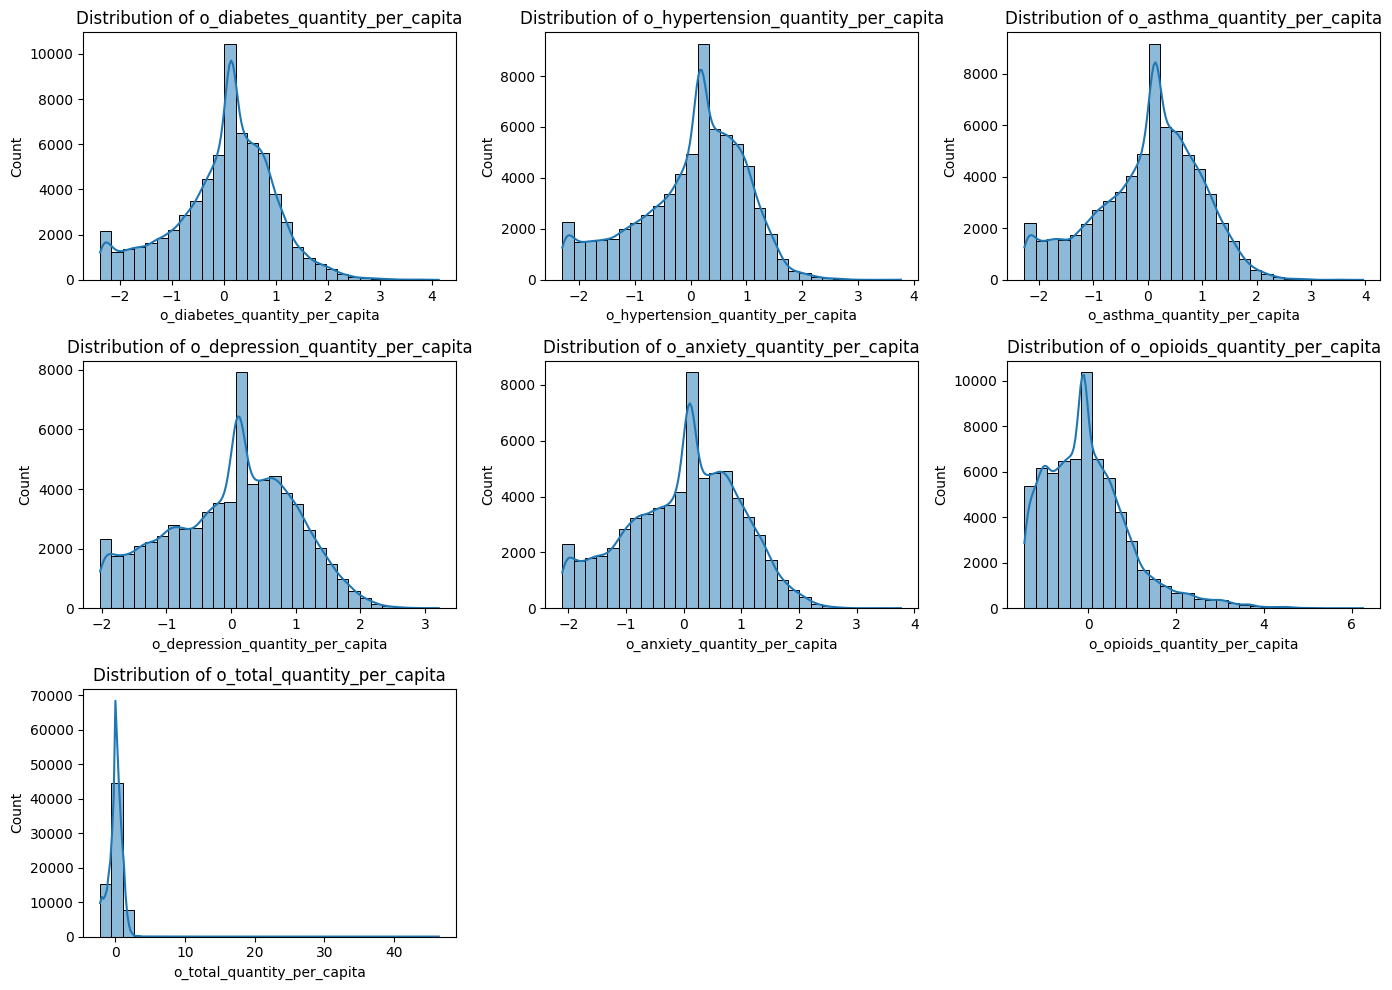

In [13]:
# Histogram Distributions for Each Outcome
import seaborn as sns

plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

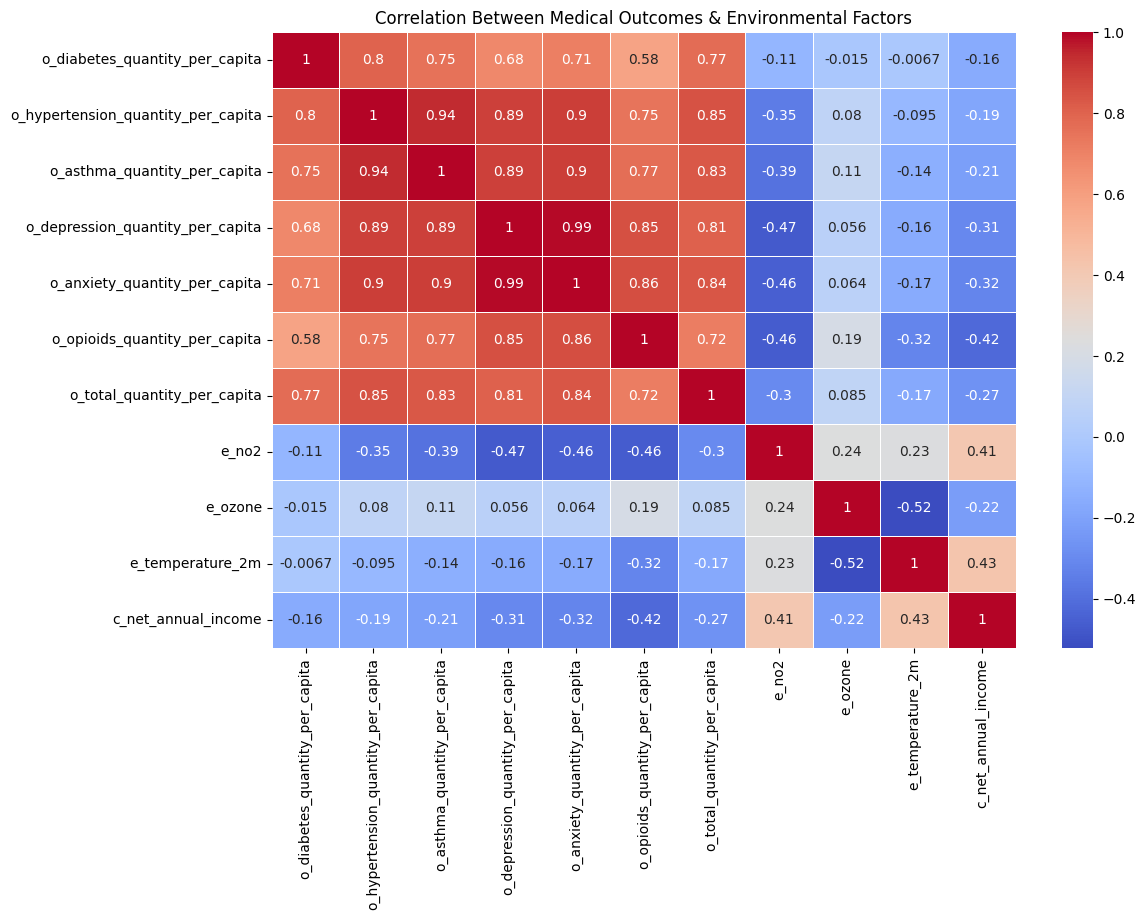

In [14]:
#  Correlation Analysis (Medical Outcomes vs Environmental Factors)
corr_features = medical_outcomes + ['e_no2', 'e_ozone', 'e_temperature_2m', 'c_net_annual_income']

plt.figure(figsize=(12, 8))
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Medical Outcomes & Environmental Factors")
plt.show()

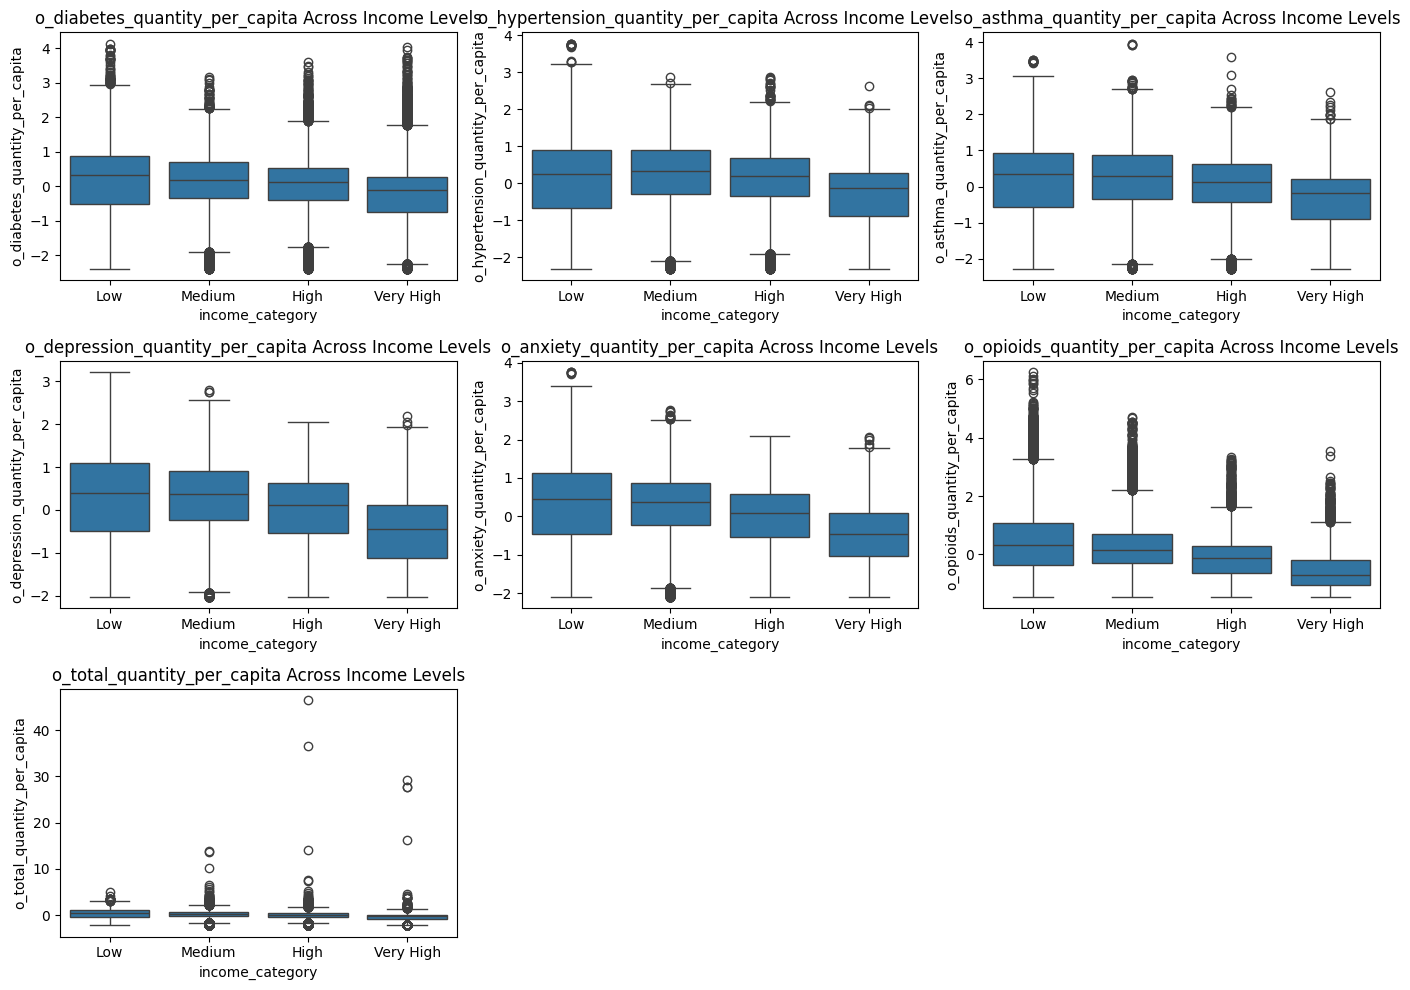

In [15]:
# Categorizing Income Levels
df['income_category'] = pd.qcut(df['c_net_annual_income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Boxplot of Disease Rates Across Income Levels
plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='income_category', y=col, data=df)
    plt.title(f"{col} Across Income Levels")

plt.tight_layout()
plt.show()

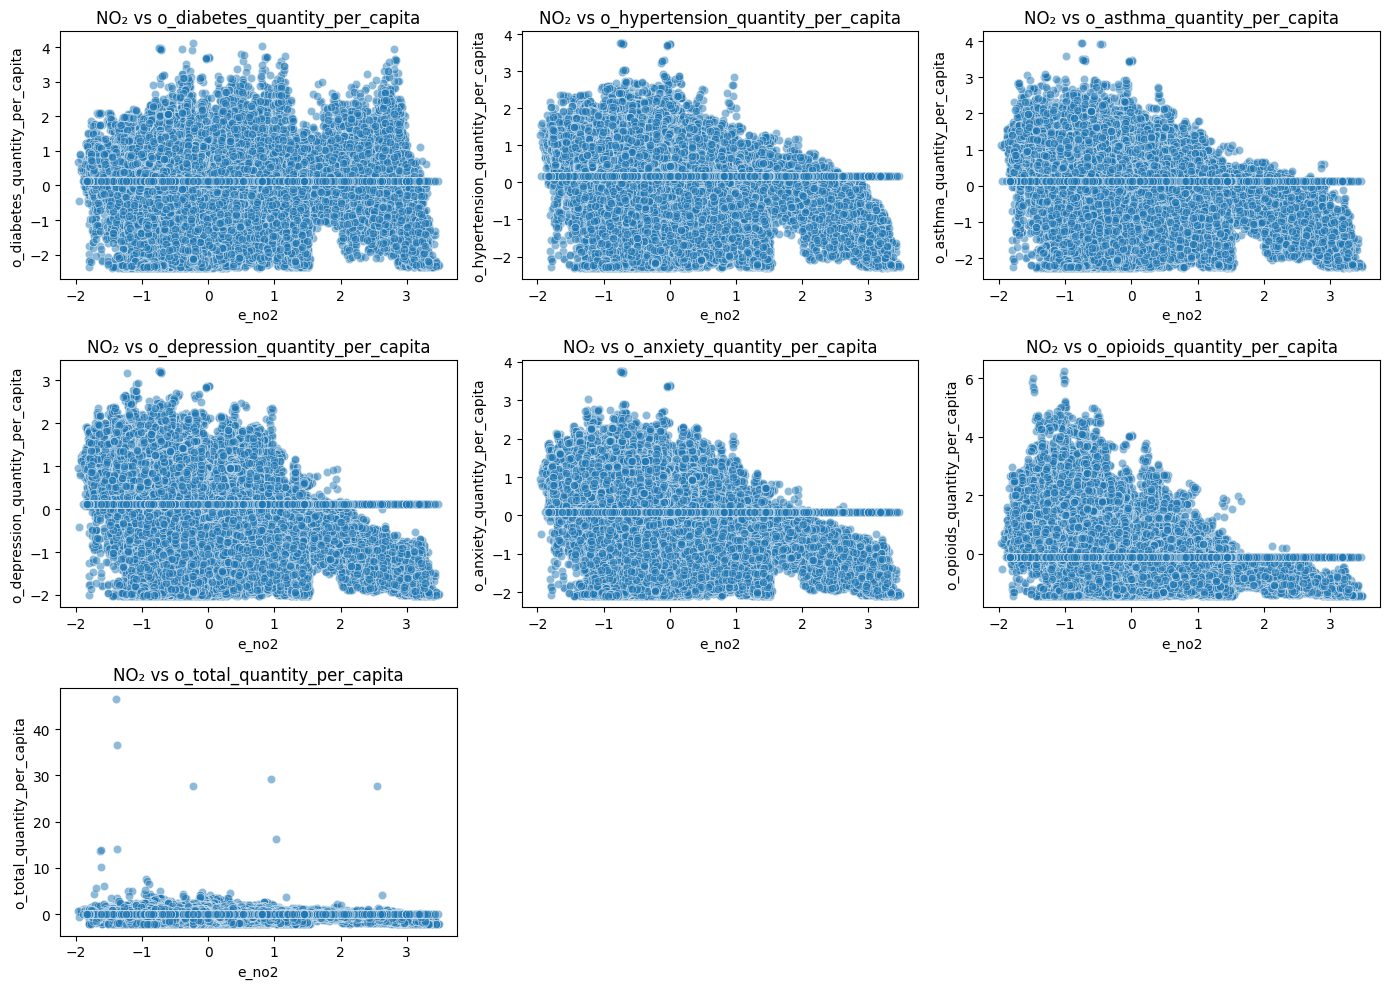

In [16]:
# Scatter Plot: NO₂ vs Each Disease Outcome
plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df['e_no2'], y=df[col], alpha=0.5)
    plt.title(f"NO₂ vs {col}")

plt.tight_layout()
plt.show()

In [18]:

#  Identify Top 10 Regions for Each Medical Condition
for disease in medical_outcomes:
    top_regions = df[['geography_code', disease]].sort_values(by=disease, ascending=False).head(10)
    print(f"\n Top 10 Regions with Highest {disease.replace('_', ' ').title()} Rates:")
    print(top_regions)


 Top 10 Regions with Highest O Diabetes Quantity Per Capita Rates:
      geography_code  o_diabetes_quantity_per_capita
9536       E01010052                        4.128876
1310       E01001364                        4.028504
24761      E01026073                        3.968245
24762      E01026074                        3.963009
24760      E01026072                        3.958840
1310       E01001364                        3.946623
24795      E01026109                        3.943225
24789      E01026103                        3.930625
5282       E01005583                        3.929738
24790      E01026104                        3.912037

 Top 10 Regions with Highest O Hypertension Quantity Per Capita Rates:
      geography_code  o_hypertension_quantity_per_capita
24761      E01026073                            3.769594
24762      E01026074                            3.766415
24760      E01026072                            3.764266
24795      E01026109                            3

<ipython-input-19-8d3dae71d06f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_regions[col], y=top_regions['geography_code'], palette="coolwarm")
<ipython-input-19-8d3dae71d06f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_regions[col], y=top_regions['geography_code'], palette="coolwarm")
<ipython-input-19-8d3dae71d06f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_regions[col], y=top_regions['geography_code'], palette="coolwarm")
<ipython-input-19-8d3dae71d06f>:7: FutureWarning: 

Passing `palette` without assigni

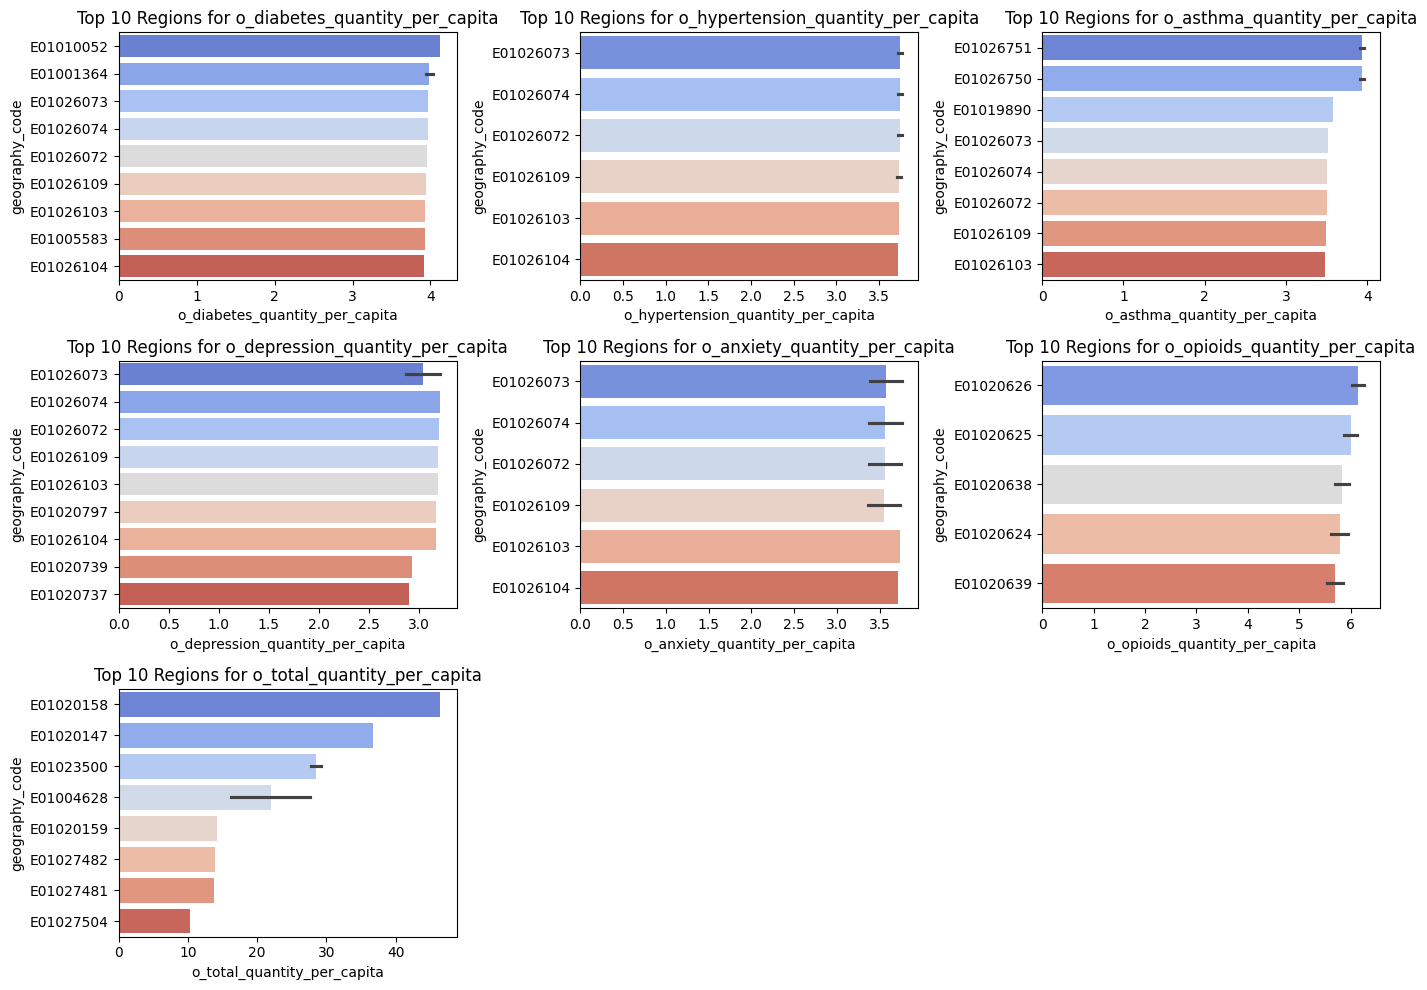

In [19]:
# Visualizing Top 10 Affected Regions Using Bar Plots
plt.figure(figsize=(14, 10))

for i, col in enumerate(medical_outcomes, 1):
    top_regions = df[['geography_code', col]].sort_values(by=col, ascending=False).head(10)
    plt.subplot(3, 3, i)
    sns.barplot(x=top_regions[col], y=top_regions['geography_code'], palette="coolwarm")
    plt.title(f"Top 10 Regions for {col}")

plt.tight_layout()
plt.show()